In [1]:
#Load datafile and import packages

fdir = "/home/julian/repositories/RTK_on_the_beach/hanglog/soper"
fdir = "/home/julian/repositories/RTK_on_the_beach/scripts/hanglog/dd_2021_04_02_172718/"

import os, sys, datetime
sys.path.append("..")
import hacktrack.loaders
import pandas, numpy, math
from scipy import optimize
from hacktrack import loaders, utils
logfiles = os.listdir(fdir)
print(logfiles)


['hdata-2021-04-02_17-27-18.log']


In [2]:
fLog = os.path.join(fdir, logfiles[0])
fd = loaders.FlyDat(fLog, lc='FLQRVWYZUISGNBXaFaZaQaV')

Extracting knowndate from filename: 2021-04-02
End found End(0,37824)

aV:250, aQ:276, aA:29708, aF:3898, aZ:3691
Parsed aF 3898 last index 3898
Parsed aZ 3691 last index 3691
Parsed aQ 276 last index 276
Setting aRdatetime0 2021-04-02 17:27:15.619481884 from 2021-04-02 17:27:13.299000 with std 28.13
Parsed aV 250 last index 250


In [3]:
print(" ".join(c  for c, d in fd.reccounts.items()  if d != 0))


aV aF aA aQ aZ


<AxesSubplot:>

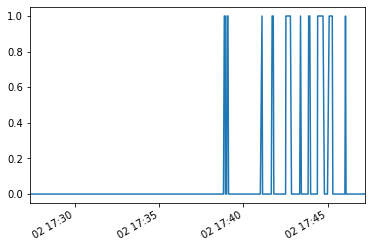

In [47]:
#fd.pZ[~fd.pZ.bad].pitch.plot()
#fd.aF.plot()
fd.aQ
fd.aV.vel.plot()

In [4]:
try:
    influxdbconfig = dict(l.split()  for l in open("../influxdb_password.txt").readlines()  if l.strip())
except FileNotFoundError:
    print("Missing password file, creating blank one to fill in")
    fpass = open("../influxdb_password.txt", "w")
    fpass.write("influxdbuser      hanglog\n")
    fpass.write("influxdbpassword      password-goes-here\n")
    fpass.close()
    influxdbconfig["influxdbpassword"] = "password-goes-here"
if influxdbconfig["influxdbpassword"] == "password-goes-here":
    print("please set the password in the file influxdb_password.txt")
    #sys.exit()



In [6]:
import influxdb
client = influxdb.InfluxDBClient(host='influxdb.doesliverpool.xyz', port=8086, 
                                 username=influxdbconfig["influxdbuser"], password=influxdbconfig["influxdbpassword"])
print("databases present", client.get_list_database())
client.switch_database('hanglogdb')

databases present [{'name': 'ming_default'}, {'name': '_internal'}, {'name': 'julianhousedb'}, {'name': 'rosebankdb'}, {'name': 'hanglogdb'}]


In [74]:
tags = { "device":"sopermodule", "uploaddate":datetime.datetime.now().isoformat()[:10] }
measurement = "hanglog"

In [170]:
def uploadfd(fd):
    tags = { "device":"sopermodule", "uploaddate":datetime.datetime.now().isoformat()[:10],
             "fname":os.path.split(fd.fname)[1] }
    measurement = "hanglog"
    rectypespresent = [k for k in fd.reccounts  if fd.reccounts[k] != 0]
    fd.LoadC("".join(rectypespresent))
    for k in rectypespresent:
        fieldkeys = None
        precs = None
        if k in "UZSXYQVGFW":
            fieldkeys = hacktrack.loaders.__getattribute__("recargs"+k)[2]
            precs = fd.__getattribute__("p"+k)
            measurement = "p"+k
        elif k[0] == "a" and k[1] in "ZQFV":
            fieldkeys = hacktrack.loaders.__getattribute__("recargsA"+k[1])[2]
            precs = fd.__getattribute__(k)
            measurement = k
        else:
            print("skipping", k)
            continue
        if k == "Z" or k == "Y":
            precs = precs[~precs["bad"]]
            precs.loc[:,"s"] = precs["s"].astype(int)
            if len(precs) == 0:
                print("skipping all bad Z")
                continue
            if (precs["mx"] == 0).all() and (precs["mx"] == 0).all() and (precs["mz"] == 0).all():
                fieldkeys.remove("mx"); fieldkeys.remove("my"); fieldkeys.remove("mz")
            fieldkeys.extend(["pitch", "roll", "heading"])

        #print(fieldkeys)
        #print(precs.head())

        tags["logchannel"] = k
        records = [ ]
        for idx, row in precs.iterrows():
            #print(row)
            fields = dict((f, row[f])  for f in fieldkeys)
            record = { "measurement":measurement, "tags":tags, "time":idx.isoformat(), "fields":fields }
            #print(record)
            records.append(record)
        print("writing %d records to channel %s" % (len(records), k))
        client.write_points(records)        
        print("  done")
    
    index_fields = { "ft0":fd.ft0.isoformat(), "ft0":fd.ft0.isoformat(), "rectypespresent":" ".join(rectypespresent) }
    record = { "measurement":measurement, "tags":tags, "time":idx.isoformat(), "fields":index_fields }
    measurement = "hanglog_index"
    client.write_points([record])

    print("all done")
    

In [172]:
logfiles = os.listdir(fdir)
for logfile in logfiles:
    print(logfile)
    fLog = os.path.join(fdir, logfile)
    fd = loaders.FlyDat(fLog)
    uploadfd(fd)


hdata-2021-03-28_10-48-33.log
Extracting knowndate from filename: 2021-03-28
Error: Should be same midnight stamps 2021-03-28 00:00:00 2021-03-27 00:00:00
End found End(8811,3247)
Z:8142, U:29, S:345, X:295, aZ:2485, aQ:72, aF:617, aV:72
linAdifftime 48100760.63192183 count 614
Made for Q 0 last index 0
Made for V 0 last index 0
Loading aQV as no pQV records
Made for aQ 72 last index 72
pCattrname aQ
Setting aRdatetime0 2021-03-28 20:24:23.918916666 from 2021-03-27 21:24:23.963000 with std 14.95
Made for aV 72 last index 72
pCattrname aV
BAD VALUES 8142 [(0, 'Zt000244AAx0000yFFF9zFFFEaFEE7b0145c0371w3E4Cx0A7Dy09E6z02ADs31m0000n0008oFFF7\n'), (0, 'Zt000244B5xFFFFyFFFBzFFFBaFEE7b0145c0371w3E4Cx0A7Dy09E6z02ADs31m0002n0002o0000\n'), (0, 'Zt000244C1xFFF6y0002z0008aFEE7b0145c0371w3E4Cx0A7Dy09E6z02ADs31m0001nFFF9o0007\n')]
Made for Z 8142 last index 0
Warning, using guessed (not GPS) timing corrected value on Z 8142
Made for U 29 last index 29
Warning, using guessed (not GPS) timing corrected

Made for U 10 last index 10
Warning, using guessed (not GPS) timing corrected value on U 10
pCattrname pU
Made for S 96 last index 96
Warning, using guessed (not GPS) timing corrected value on S 96
pCattrname pS
Made for X 82 last index 82
Warning, using guessed (not GPS) timing corrected value on X 82
pCattrname pX
Made for aZ 519 last index 519
pCattrname aZ
Made for aA 519 last index 519
pCattrname aA
Made for aF 171 last index 171
pCattrname aF
skipping all bad Z
writing 10 records to channel U
  done
writing 96 records to channel S
  done
writing 82 records to channel X
  done
writing 519 records to channel aZ
  done
skipping aA
writing 171 records to channel aF
  done
all done
hdata-2021-03-30_17-03-31.log
Extracting knowndate from filename: 2021-03-30
End found End(23206,11708)

Z:21470, U:78, S:894, X:764, aZ:5067, aA:5126, aF:1507
linAdifftime 6823479.271628499 count 1572
Made for Q 0 last index 0
Made for V 0 last index 0
Loading aQV as no pQV records
Made for aQ 0 last index

In [6]:
logfiles = os.listdir(fdir)
logfile = logfiles[0]
print(logfile)
fLog = os.path.join(fdir, logfile)
fd = loaders.FlyDat(fLog)
fd.LoadC("aZ")

hdata-2021-03-28_10-48-33.log
Extracting knowndate from filename: 2021-03-28
Error: Should be same midnight stamps 2021-03-28 00:00:00 2021-03-27 00:00:00
End found End(8811,3247)
Z:8142, U:29, S:345, X:295, aF:617, aQ:72, aV:72, aZ:2485
linAdifftime 48100760.63192183 count 614
Made for Q 0 last index 0
Made for V 0 last index 0
Loading aQV as no pQV records
Made for aQ 72 last index 72
pCattrname aQ
Setting aRdatetime0 2021-03-28 20:24:23.918916666 from 2021-03-27 21:24:23.963000 with std 14.95
Made for aV 72 last index 72
pCattrname aV
Made for aZ 2485 last index 2485
pCattrname aZ


1

In [4]:
fd.pZ

,ax,ay,az,gx,gy,gz,q0,q1,q2,q3,s,mx,my,mz,iqsq,pitch,roll,heading,bad
2021-03-30 17:03:31.131272,-0.09,0.06,-0.07,-5.81,3.93,6.84,4936.0,-3819.0,5099.0,14265.0,247.0,-0.091111,0.027778,-0.046667,3.725243e-09,23.670840,-36.399124,298.132376,False
2021-03-30 17:03:31.145272,-0.14,0.02,-0.02,-5.82,3.92,6.84,4929.0,-3831.0,5087.0,14268.0,247.0,-0.065556,0.035556,-0.044444,3.725435e-09,23.584382,-36.447909,298.092871,False
2021-03-30 17:03:31.157272,-0.15,-0.12,-0.05,-5.83,3.91,6.84,4930.0,-3836.0,5085.0,14267.0,247.0,-0.032222,0.046667,-0.042222,3.725445e-09,23.555521,-36.481316,298.101060,False
2021-03-30 17:03:31.169272,-0.16,-0.27,-0.06,-5.83,3.91,6.84,4932.0,-3842.0,5083.0,14266.0,247.0,-0.020000,0.044444,-0.041111,3.725210e-09,23.520943,-36.522225,298.115768,False
2021-03-30 17:03:31.182272,-0.12,-0.13,-0.08,-5.84,3.91,6.83,4904.0,-3859.0,5078.0,14272.0,247.0,0.021111,0.041111,0.012222,3.725544e-09,23.515425,-36.578554,297.877612,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-30 17:08:50.555272,-0.03,0.06,-0.29,-7.04,2.53,6.33,12597.0,-1464.0,6733.0,7891.0,54.0,0.006667,0.023333,-0.002222,3.725382e-09,14.978276,-45.890865,16.552097,False
2021-03-30 17:08:50.567272,0.04,0.12,-0.13,-7.04,2.53,6.33,12597.0,-1466.0,6732.0,7891.0,54.0,-0.025556,0.010000,-0.012222,3.725487e-09,14.964089,-45.894494,16.559875,False
2021-03-30 17:08:50.578272,-0.07,0.06,-0.28,-7.04,2.53,6.33,12596.0,-1466.0,6732.0,7893.0,54.0,-0.008889,0.002222,0.000000,3.725399e-09,14.970323,-45.890759,16.540166,False
2021-03-30 17:08:50.590272,0.09,-0.06,-0.17,-7.04,2.53,6.33,12595.0,-1467.0,6734.0,7893.0,54.0,0.007778,0.031111,0.007778,3.725334e-09,14.972114,-45.905894,16.528768,False


In [178]:
fd.LoadC("Z")

BAD VALUES 21470 [(0, 'Zt00005311xFFF7y0006zFFF9aFDBBb0189c02ACw1348xF115y13EBz37B9sF7mFFAEn0019oFFD6\n'), (0, 'Zt0000531FxFFF2y0002zFFFEaFDBAb0188c02ACw1341xF109y13DFz37BCsF7mFFC5n0020oFFD8\n'), (0, 'Zt0000532BxFFF1yFFF4zFFFBaFDB9b0187c02ACw1342xF104y13DDz37BBsF7mFFE3n002AoFFDA\n')]
Made for Z 21470 last index 0
Warning, using guessed (not GPS) timing corrected value on Z 21470


0

In [181]:
'Zt00005311xFFF7y0006zFFF9aFDBBb0189c02ACw1348xF115y13EBz37B9sF7mFFAEn0019oFFD6\n'
hacktrack.loaders.linfuncZ('Zt00005311xFFF7y0006zFFF9aFDBBb0189c02ACw1348xF115y13EBz37B9sF7mFFAEn0019oFFD6\n')

(21265,
 -0.09,
 0.06,
 -0.07,
 -5.8100000000000005,
 3.93,
 6.84,
 4936,
 -3819,
 5099,
 14265,
 247,
 -0.09111111111111111,
 0.027777777777777776,
 -0.04666666666666667)

In [24]:
k = client.query("SELECT * FROM hanglog_index")
print(len(k))

1


In [28]:
pK = pandas.DataFrame(k.get_points())
pK = pK.drop(columns=["logchannel", "time"], errors="ignore")
pK

,devicename,fdir,fname,ft0,rectypespresent,uploaddate
0,sopermodule,dd_2020_12_06_145800,hdata-2020-12-06_14-58-00.log,2020-12-06T14:58:00.588000,aQ aZ aF aA aV,2021-04-02
1,pendulums,dd_2020_12_11_091846,hdata-2020-12-11_09-18-46.log,2020-12-11T09:18:46.339995,Y Z U aF aZ aA,2021-04-02
2,sopermodule,dd_2020_12_11_091846,hdata-2020-12-11_09-18-46.log,2020-12-11T09:18:46.339995,Y Z U aZ aF aA,2021-04-02
3,sopermodule,dd_2020_12_11_101346,hdata-2020-12-11_10-13-46.log,2020-12-11T10:13:46.256237,Y Z U aZ aA aF,2021-04-02
4,sopermodule,dd_2021_04_02_172718,hdata-2021-04-02_17-27-18.log,2021-04-02T17:27:18.106000,aV aZ aA aF aQ,2021-04-02


In [30]:
(pK.fname=='hdata-2020-12-06_14-58-00.log').any()

True

In [143]:
fd = { }
for kk in ["pZ", "pS", "pX", "aQ", "aF"]:
    print("fetching", kk)
    k = client.query("SELECT * FROM %s where uploaddate='2021-04-01'" % kk)
    pK = pandas.DataFrame(k.get_points())
    ds = pandas.DatetimeIndex(pK.time)
    pK = pK.set_index(ds)
    pK.index.name = ""
    pK = pK.drop(columns=["time", "logchannel", "uploaddate", "device"])
    fd[kk] = pK
    print("   ", len(pK), "records")

fetching pZ
    8122 records
fetching pS
    345 records
fetching pX
    295 records
fetching aQ
    72 records
fetching aF
    617 records


In [144]:
fd["aQ"]

,alt,lat,lng,u
,,,,
2021-03-29 09:48:34+00:00,47.0,51.061957,-3.140532,121714000
2021-03-29 09:48:36+00:00,47.1,51.061985,-3.140537,121716000
2021-03-29 09:48:39+00:00,47.3,51.061988,-3.140555,121719000
2021-03-29 09:48:41+00:00,47.4,51.061978,-3.140560,121721000
2021-03-29 09:48:42+00:00,47.5,51.061992,-3.140580,121722000
...,...,...,...,...
2021-03-29 09:50:29+00:00,46.0,51.061928,-3.140453,121829000
2021-03-29 09:50:30+00:00,46.0,51.061923,-3.140468,121830000
2021-03-29 09:50:31+00:00,46.0,51.061902,-3.140488,121831000
